Setting up Langsmith 


In [ ]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langgraph"

In [14]:
# Defining a conversation
from langchain_core.messages import HumanMessage, AIMessage, AnyMessage, SystemMessage
messages = [AIMessage(content = 'Football is a game played with the feet!')]
messages.append(HumanMessage("Yes I got it, what about handball?"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================

Football is a game played with the feet!
================================ Human Message =================================

Yes I got it, what about handball?


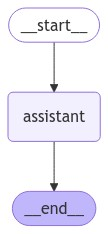

In [12]:
# Creating the llm object
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = 'gpt-3.5-turbo')

# Creating a basic chatbot graph
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Defining the node function for llm
def assistant(state: MessagesState):
    return{'messages': llm.invoke(state['messages'])}

# Build Graph
builder = StateGraph(MessagesState)
builder.add_node('assistant',assistant)
builder.add_edge(START,'assistant')
builder.add_edge('assistant',END)

# Compiling the graph
graph = builder.compile()

# Visualizing the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
# Feeding the conversation to this graph
output = graph.invoke({'messages':messages})
for o in output['messages']:
    o.pretty_print()


================================== Ai Message ==================================

Football is a game played with the feet!
================================ Human Message =================================

Yes I got it, what about handball?
================================== Ai Message ==================================

Handball is a team sport in which players use their hands to pass and shoot a ball into the opponent's goal. It is similar to soccer but with the main difference being that players use their hands instead of their feet to control the ball. Handball is played on a court with six players on each team, and the objective is to score more goals than the opposing team.


Strategy:1
Filtering messages


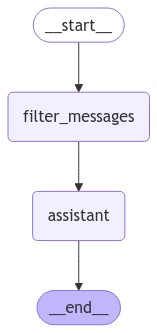

In [18]:
from langchain_core.messages import RemoveMessage

# Defining the node function for filter operation
def filter_messages(state:MessagesState):
    """
    Deleting all messages except for the 2 recent ones

    """
    remove_messages = [RemoveMessage(id = m.id) for m in state['messages'][:-2]]
    return {'messages':remove_messages}

# Now bulding graph to include this node
builder = StateGraph(MessagesState)
builder.add_node("filter_messages", filter_messages)
builder.add_node("assistant", assistant)
builder.add_edge(START, "filter_messages")
builder.add_edge("filter_messages", "assistant")
builder.add_edge("assistant", END)
graph = builder.compile()

# Visualize
display(Image(graph.get_graph().draw_mermaid_png()))


In [23]:
# Testing this graph

# Sample conversation history
messages = [AIMessage("Hello, what can I do for you?", id="1")]
messages.append(HumanMessage("Hi I'm Fiddler", id="2"))
messages.append(AIMessage("Hi, Fiddler tell me what can I do for you?", id="3"))
messages.append(HumanMessage("Teach me football", id="4"))

# Invoking our graph
output = graph.invoke({'messages':messages})
for o in output['messages']:
    o.pretty_print()

# https://smith.langchain.com/public/c5285bf3-8aa4-4530-86d2-1a713f58178b/r

================================== Ai Message ==================================

Hi, Fiddler tell me what can I do for you?
================================ Human Message =================================

Teach me football
================================== Ai Message ==================================

Sure! Football, also known as soccer in some countries, is a popular sport played by two teams of eleven players each, using a spherical ball. The objective of the game is to score goals by getting the ball into the opposing team's goal. Here are some basic rules and concepts of football:

1. **Field**: Football is played on a rectangular field with goalposts at each end. The field is divided into two halves, with a center circle and penalty areas at each end.

2. **Duration**: A standard football match consists of two halves, each lasting 45 minutes, with a 15-minute halftime break.

3. **Players**: Each team has 11 players, including a goalkeeper. Players are assigned specific posit

Strategy: 2 Trimming

Trim messages to be below a token count.

trim_messages can be used to reduce the size of a chat history to a specified token count or specified message count.


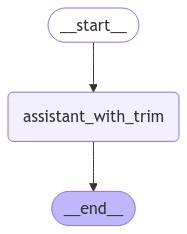

In [35]:
from langchain_core.messages import trim_messages

# Node function for assistant (llm) responding on trimmed messages
def assistant_with_trim(state: MessagesState):
    messages = trim_messages(
        state['messages'],
        max_tokens = 50,
        strategy = 'last',# To retain the recent messages and trim the old ones
        token_counter = ChatOpenAI(model = 'gpt-3.5-turbo'),
        allow_partial = False, # No partial messages
     )
    return {'messages': llm.invoke(messages)}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("assistant_with_trim", assistant_with_trim)
builder.add_edge(START, "assistant_with_trim")
builder.add_edge("assistant_with_trim", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
# Testing the trim strategy graph
# Sample convo history
messages = [
    AIMessage(content='Artificial intelligence is reshaping various industries, enabling machines to learn from data and perform tasks that typically require human intelligence. From language processing to decision-making, AI has a profound impact on our daily lives.'),
    HumanMessage(content="That's fascinating! What are some of the most promising applications of AI right now?"),
    AIMessage(content='One of the most promising applications is in healthcare. AI systems are being used to analyze medical images for early detection of diseases, as well as to personalize treatment plans based on patient data.'),
    HumanMessage(content="I see how that could be a game changer. But what about the ethical implications? How should we address them as football continues to evolve?")
]

output = graph.invoke({'messages': messages})
for o in output['messages']:
    o.pretty_print()

# lsmith: https://smith.langchain.com/public/43e6c4c8-3669-4112-85c4-3bb818535844/r

[HumanMessage(content='I see how that could be a game changer. But what about the ethical implications? How should we address them as football continues to evolve?', additional_kwargs={}, response_metadata={}, id='32480816-b062-4693-9e61-e73c772332e5')]
================================== Ai Message ==================================

Artificial intelligence is reshaping various industries, enabling machines to learn from data and perform tasks that typically require human intelligence. From language processing to decision-making, AI has a profound impact on our daily lives.
================================ Human Message =================================

That's fascinating! What are some of the most promising applications of AI right now?
================================== Ai Message ==================================

One of the most promising applications is in healthcare. AI systems are being used to analyze medical images for early detection of diseases, as well as to personalize t

Strategy: 3 Summarization

Summarizing helps us retain an abstracted/compressed version of the conversation history.

In [39]:
# Defining a state schema to store messages and summary

class State(MessagesState):
    summary: str

# Defining the node function to create summaries
def summarizer(state: State):

    # Getting any existing summary
    summary = state.get('summary','')

    # If summary exists:
    if summary:

        # Prompt to generate summary
        summary_message  = (f"""Summary of the conversation history : {summary}\n
                            Extend the summary considering the new messages above:""")
        
    # if summary doesn't exist
    else:

        summary_message = "Generate a structured summary of the conversation above:"

    # Adding the summary message to messages
    messages = state['messages'] + [HumanMessage(content = summary_message)]
    response = llm.invoke(messages)

    # Them, filtering the messages state to retain only the two recent ones
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}



In [40]:
# Define the assistant node

def assistant(state:State):

    summary = state.get('summary','')

    # If summary exists:
    if summary:

        # Add summary to the system message
        sys_msg = f'Summary of the conversation history : {summary}'

        # Append the summary to newer messages for context
        messages = [SystemMessage(content = sys_msg)] + state['messages']

    # If summary doesn't exist
    else:

        messages = state['messages']

    response = llm.invoke(messages)

    return {'messages': response}

In [41]:
# Adding a conditional edge to decide if we should summarize or not
from langgraph.graph import END
# Determine whether to end or summarize the conversation
def summarize_decision(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarizer"
    
    # Otherwise we can just end
    return END

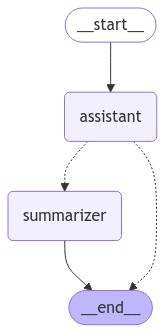

In [52]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

# Building the graph

builder = StateGraph(State)
builder.add_node('assistant',assistant)
builder.add_node('summarizer',summarizer)
builder.add_edge(START,'assistant')
builder.add_conditional_edges('assistant',summarize_decision)
builder.add_edge('summarizer',END)


graph_summarizer = builder.compile(checkpointer = memory)

display(Image(graph_summarizer.get_graph().draw_mermaid_png()))

In [64]:
config = {"configurable": {"thread_id": "4"}}

# Start conversation
input_message = HumanMessage(content="Hi! AdolfFiddler here!")
output = graph_summarizer.invoke({"messages": [input_message]}, config) 
for m in output['messages']:
    m.pretty_print()





================================ Human Message =================================

Hi! AdolfFiddler here!
================================== Ai Message ==================================

Hello AdolfFiddler! How can I assist you today?


In [65]:
input_message = HumanMessage(content="What's my name?!")
output = graph_summarizer.invoke({"messages": [input_message]}, config) 
for m in output['messages']:
    m.pretty_print()


================================ Human Message =================================

Hi! AdolfFiddler here!
================================== Ai Message ==================================

Hello AdolfFiddler! How can I assist you today?
================================ Human Message =================================

What's my name?!
================================== Ai Message ==================================

Your name is AdolfFiddler! How can I help you today?


In [66]:
input_message = HumanMessage(content="I love Messi, he is the most skillful player right?")
output = graph_summarizer.invoke({"messages": [input_message]}, config) 
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi! AdolfFiddler here!
================================== Ai Message ==================================

Hello AdolfFiddler! How can I assist you today?
================================ Human Message =================================

What's my name?!
================================== Ai Message ==================================

Your name is AdolfFiddler! How can I help you today?
================================ Human Message =================================

I love Messi, he is the most skillful player right?
================================== Ai Message ==================================

Lionel Messi is definitely considered one of the most skillful and talented football players in the world. He has achieved numerous records and accolades throughout his career. Many people admire his dribbling ability, vision, and goal-scoring prowess. It's great to hear that you are a fan of Messi!


In [67]:
input_message = HumanMessage(content="Tell me one key fact about him")
output = graph_summarizer.invoke({"messages": [input_message]}, config) 
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================

Tell me one key fact about him
================================== Ai Message ==================================

One key fact about Lionel Messi is that he has won the prestigious FIFA Ballon d'Or award multiple times, which is given to the best male football player in the world. Messi has won this award multiple times, showcasing his exceptional talent and skill on the field.


In [69]:
output['summary']
# Langsmith link: https://smith.langchain.com/public/821e44be-58cd-434f-9517-dd1d303e1561/r

"Sure! Here is a structured summary of our conversation:\n\n1. User (AdolfFiddler) mentioned their admiration for Lionel Messi, considering him the most skillful player.\n2. AdolfFiddler asked for confirmation of their name, which was confirmed as AdolfFiddler.\n3. AdolfFiddler expressed their love for Messi and his skillful playing style.\n4. AdolfFiddler asked for a key fact about Messi, learning that he has won the FIFA Ballon d'Or award multiple times for being the best male football player in the world."